In [37]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# display the figures in the Notebook
%matplotlib inline

## Part 2: Wenzinger's test case

In [38]:
x_wing,y_wing = numpy.loadtxt(open("NACA23012_MainFoil.csv","rb"),delimiter=",",skiprows=0,unpack=True) 
x_flap,y_flap = numpy.loadtxt(open("NACA23012_FlapFoil.csv","rb"),delimiter=",",skiprows=0,unpack=True)


In [39]:
def rotation (x,y,theta):
    x_point=1.03
    y_point=-0.054
    angle=theta/180*numpy.pi
    x1,y1=0,0
    x1=x-x_point*numpy.ones_like(x)
    y1=y-y_point*numpy.ones_like(y)
    xr=x1*numpy.cos(angle)+y1*numpy.sin(angle)+x_point*numpy.ones_like(x)
    yr=x1*(-1)*numpy.sin(angle)+y1*numpy.cos(angle)+y_point*numpy.ones_like(y)
    return xr,yr

In [40]:
theta=20
x_f_d,y_f_d=rotation(x_flap,y_flap,theta)

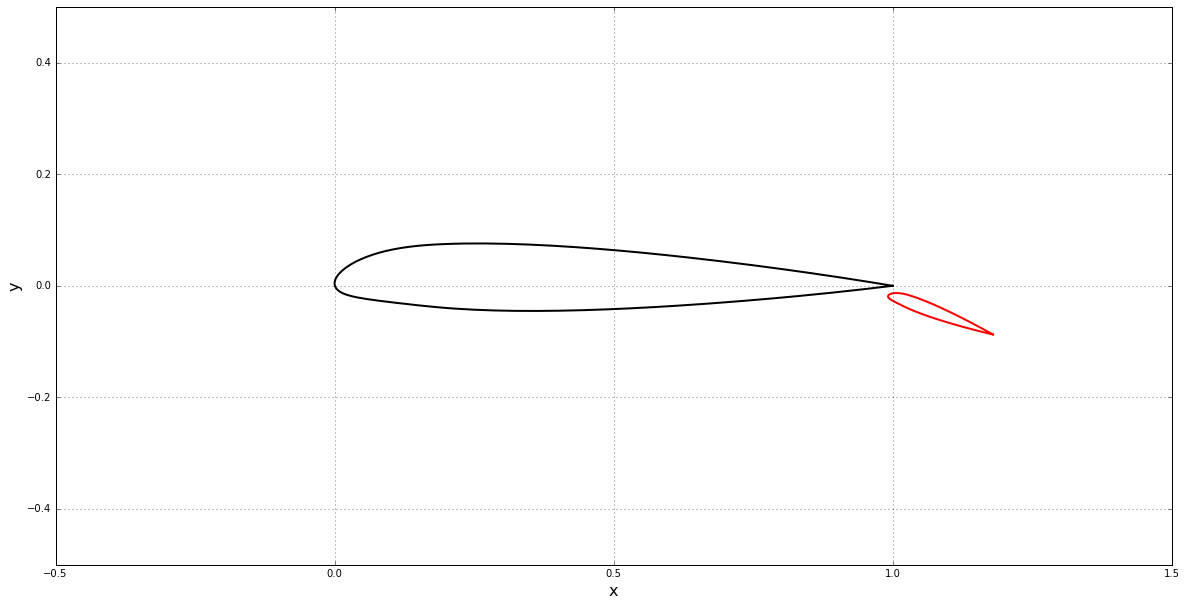

In [41]:
# plot the geometry
width = 20
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_wing,y_wing, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_f_d,y_f_d, color='red', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.5, 1.5)
pyplot.ylim(-0.5, 0.5);

In [42]:
class Panel:
  
    def __init__(self, xa, ya, xb, yb):
  
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [43]:
def define_panels(x, y, N):
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [44]:
N=numpy.size(x_wing)-1
print (N)

150


In [45]:
panels_wing = define_panels(x_wing, y_wing, N)
panels_flap = define_panels(x_f_d, y_f_d, N)
total_panels = numpy.concatenate((panels_wing,panels_flap))

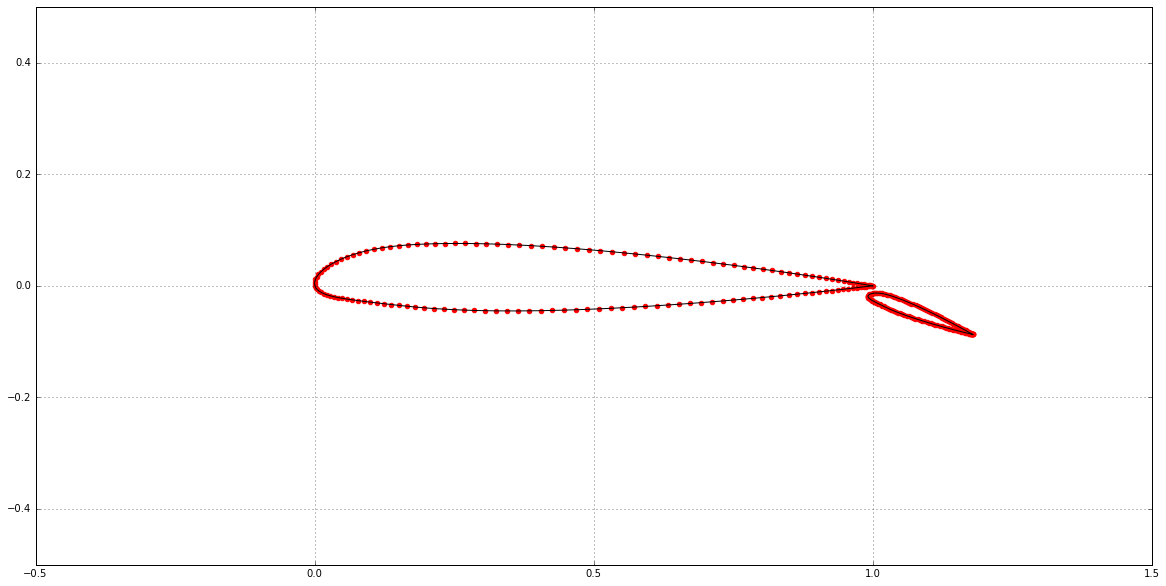

In [46]:
pyplot.figure(figsize=(20,10))
pyplot.plot(x_wing, y_wing, x_f_d, y_f_d,  color='k', linestyle='-', linewidth=1);
pyplot.grid(True)
pyplot.scatter([panel.xa for panel in panels_wing], [panel.ya for panel in panels_wing], color='red');
pyplot.scatter([panel.xa for panel in panels_flap], [panel.ya for panel in panels_flap], color='red');
pyplot.xlim(-0.5, 1.5)
pyplot.ylim(-0.5, 0.5);

In [47]:
class Freestream:

    def __init__(self, u_inf=1.0, alpha=0.0):

        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [48]:
def integral(x, y, panel, dxdk, dydk):
 
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [49]:
def source_contribution_normal(panels):

    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [50]:
def vortex_contribution_normal(panels):
 
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [51]:
def kutta_condition(A_source, B_vortex):
   
    b = numpy.empty([2,A_source.shape[0]+2],dtype=float)
    M = len(x_wing)+len(x_flap)-2
   
    b[0,:-2] = B_vortex[0, :] + B_vortex[M/2-1, :]
    b[1,:-2] = B_vortex[M/2, :] + B_vortex[M-1, :]
    
    b[-2,-2]=- numpy.sum(A_source[0,:M/2] + A_source[M/2-1,:M/2])
    b[-2,-1]=- numpy.sum(A_source[0,M/2:] + A_source[M/2-1,M/2:])
    
    b[-1,-2]=- numpy.sum(A_source[M/2,:M/2] + A_source[M-1,:M/2])
    b[-1,-1]=- numpy.sum(A_source[M/2,M/2:] + A_source[M-1,M/2:])
    return b

In [52]:
def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    M = len(x_wing)+len(x_flap)-2
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:M/2], axis=1)    
    A[:-2, -1] = numpy.sum(B_vortex[:,M/2:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    
    return A

In [53]:
def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size+2,dtype=float)
    M = len(x_wing)+len(x_flap)-2
    for i, panel in enumerate(panels):
        b[i] = - freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    b[-2] = -freestream.u_inf*( math.sin(freestream.alpha-panels[0].beta)
                              +math.sin(freestream.alpha-panels[M/2-1].beta) )
    b[-1] = -freestream.u_inf*( math.sin(freestream.alpha-panels[M/2].beta)
                              +math.sin(freestream.alpha-panels[M-1].beta) )
    
    return b

In [54]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels],gamma)
    tangential_velocities = numpy.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [55]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [65]:
def lift (aoa,flap_angle):
    u_inf = 1.0
    freestream = Freestream(u_inf, aoa)
    
    
    x_f_d,y_f_d=rotation(x_flap,y_flap,flap_angle)

    
    panels_wing = define_panels(x_wing, y_wing, N)
    panels_flap = define_panels(x_f_d, y_f_d, N)
    total_panels = numpy.append(panels_wing,panels_flap)
   
    
    A_source = source_contribution_normal(total_panels)
    B_vortex = vortex_contribution_normal(total_panels)
    
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(total_panels, freestream)
    
  
    # solve for singularity strengths
    strengths = numpy.linalg.solve(A, b)

    # store source strength on each panel
    for i , panel in enumerate(total_panels):
        panel.sigma = strengths[i]
    
    # store circulation density
    gamma=numpy.append(strengths[-2], strengths[-1])
    
    
    compute_tangential_velocity(total_panels, freestream, gamma, A_source, B_vortex)
    for panel in total_panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2
        
    lift =0.0    
    for panel in total_panels: 
        lift -= panel.cp*numpy.sin(panel.beta)*panel.length
    
    return lift

In [66]:
def bisection_method_Q1(a,b,flap_angle,tol):
    n = 1 
    La = lift(a,flap_angle)
    Lb= lift(b,flap_angle)
    while n < 100: 
        alpha = 0.5*(a+b)
        Lc = lift (alpha,flap_angle)
        print('flap_angle: ', alpha, 'Lift: ', Lc)
        
        if abs(b-a)/2 < tol: 
            break
        
        if numpy.sign(Lc) == numpy.sign(La):
            a = alpha
            La=Lc
        else:
            b = alpha
    
        n = n+1
    return alpha

In [58]:
bisection_method_Q1(-14,14,20,0.01)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main

flap_angle:  0.0 Lift:  1.52018626053
flap_angle:  -7.0 Lift:  0.548338462552
flap_angle:  -10.5 Lift:  0.063498906204
flap_angle:  -12.25 Lift:  -0.175476948754
flap_angle:  -11.375 Lift:  -0.0563695467263
flap_angle:  -10.9375 Lift:  0.00347652142468
flap_angle:  -11.15625 Lift:  -0.0264694255558
flap_angle:  -11.046875 Lift:  -0.0115020712276
flap_angle:  -10.9921875 Lift:  -0.00401416604987
flap_angle:  -10.96484375 Lift:  -0.00026916839389
flap_angle:  -10.951171875 Lift:  0.00160359020833
flap_angle:  -10.9580078125 Lift:  0.0006671893038


-10.9580078125

The result above seems not right, So I am going to chose -10.96484 which has the lift ≈ 0

In [67]:
def bisection_method_Q2(a,b,aoa,tol): 
    n = 1 
    La = lift(aoa,a)
    Lb= lift(aoa,b)
    while n < 100: 
        theta = 0.5*(a+b)
        Lc = lift (aoa,theta)
        print('AOA: ', theta, 'Lift: ', Lc)
        
        if abs(b-a)/2 < tol: 
            break
        
        
        if numpy.sign(Lc) == numpy.sign(La):
            a = theta
            La=Lc
        else:
            b = theta
    
        n = n+1
    return theta

In [68]:
bisection_method_Q2(-10,10,0,0.01)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main

AOA:  0.0 Lift:  0.271910644469
AOA:  -5.0 Lift:  -0.0292849385314
AOA:  -2.5 Lift:  0.120733957722
AOA:  -3.75 Lift:  0.0455783940187
AOA:  -4.375 Lift:  0.00811001236129
AOA:  -4.6875 Lift:  -0.0105966660811
AOA:  -4.53125 Lift:  -0.00124562455172
AOA:  -4.453125 Lift:  0.0034316198606
AOA:  -4.4921875 Lift:  0.00109285409619
AOA:  -4.51171875 Lift:  -7.642112325e-05
AOA:  -4.501953125 Lift:  0.000508207513393


-4.501953125

In [70]:
# given aoa=4.0
L1=lift(4,0)
L2=lift(4,5)
L3=lift(4,10)
L4=lift(4,15)

diff1=1-numpy.sqrt(L1/L2)
diff2=1-numpy.sqrt(L1/L3)
diff3=1-numpy.sqrt(L1/L4)

print(diff1)
print(diff2)
print(diff3)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main

0.145141136357
0.242124090158
0.312809103274
